In [1]:
import os
import collections
import tikzplotlib
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("test.txt", sep="\t")

In [20]:
def normalize_ats(ats):
    h, m, s = ats.split(":")
    return (60*int(h) + int(m) + int(s)/60)/30

df["Ats/Dur"] = df["Ats(viewer)"].apply(lambda x: normalize_ats(x))
df["Est. rat%"] = df["Ats/Dur"] * df["Daily Avg Rch%"]
display(df.head())
display((df["Est. rat%"] - df["rat%/AP"]).abs().describe())

,rat%/AP,Daily Avg Rch%,Daily Avg Rch'000,Ats(viewer),Ats/Dur,Est. rat%
0,20.61,29.92,"22,366.38",0:21:22,0.712222,21.309689
1,19.23,29.50,"22,052.92",0:20:52,0.695556,20.518889
2,16.77,26.42,"19,750.66",0:19:49,0.660556,17.451878
3,14.04,23.83,"17,818.20",0:17:37,0.587222,13.993506
4,10.99,19.86,"14,844.71",0:16:20,0.544444,10.812667


count    97.000000
mean      2.470566
std       4.301874
min       0.004206
25%       0.057489
50%       0.472278
75%       2.702994
max      27.327667
dtype: float64

## Read excel and samples

In [2]:
data_dir = os.path.join(os.getenv("DATA_DIR"), "narrative_understanding/chatter")
ratings_file = os.path.join(data_dir, "attr_analyze/ratings.xlsx")
samples_file = os.path.join(data_dir, "attr_annot/samples.csv")
tex_file = os.path.join(data_dir, "attr_analyze/plot.tex")
xl = pd.read_excel(ratings_file, index_col=None, sheet_name=list(range(1, 17)))
samples_df = pd.read_csv(samples_file, index_col=None)

## Create error df and percent error df

In [3]:
# (attribute, n) + (zero, few, cot) x 
# (n, correct_n, wrong_n, wrong_answer_exists_n, wrong_diff_character_n, wrong_diff_attr_n, 
# wrong_wrong_n)

attrs, attrs_n = [], []
data_rows = []
for df in xl.values():
    attr = df["attribute"].values[0]
    if attr not in ["physical health status", "physical appearance", "possessions"]:
        mask = df["Expert"].notna() & df["Expert"].str.match(r"(CORRECT)|(WRONG)")
        n = df.loc[mask, "index"].unique().size
        attrs.append(attr)
        attrs_n.append(n)
        data_row = []
        for prompt in ["zero", "few", "cot"]:
            prompt_mask = df["strategies"].str.contains(prompt) & mask
            n = df.loc[prompt_mask, "index"].unique().size
            correct = (prompt_mask & (df["Expert"] == "CORRECT")).sum()
            wrong = (prompt_mask & (df["Expert"] == "WRONG")).sum()
            wrong_answer_exists = (prompt_mask & (df["Expert"] == "WRONG") & (df["Reason"] == "ANSWER EXISTS")).sum()
            wrong_diff_character = (prompt_mask & (df["Expert"] == "WRONG") & (df["Reason"] == "DIFF CHARACTER")).sum()
            wrong_diff_attribute = (prompt_mask & (df["Expert"] == "WRONG") & (df["Reason"] == "DIFF ATTRIBUTE")).sum()
            wrong_wrong = (prompt_mask & (df["Expert"] == "WRONG") & (df["Reason"] == "WRONG/MISSING")).sum()
            data_row.extend([n, correct, wrong, wrong_answer_exists, wrong_diff_character, wrong_diff_attribute, 
                             wrong_wrong])
        data_rows.append(data_row)

ix = pd.MultiIndex.from_product([["zero", "few", "cot"], 
                                 ["n", "correct", "wrong", "Rexists","RdiffCh", "RdiffAt", "Rwrong"]])
jx = pd.MultiIndex.from_arrays([attrs, attrs_n], names=["attribute", "n"])
df = pd.DataFrame(data_rows, index=jx, columns=ix)
df

zero                                              few  \
                      n correct wrong Rexists RdiffCh RdiffAt Rwrong   n   
attribute       n                                                          
accomplishments 45   45      29    16       0       1       0     13  45   
age             53   53      52     1       1       0       0      0  53   
attire          49   49      42     7       4       0       0      2  49   
attitude        46   45      39     6       0       0       0      6  46   
demeanor        50   50      36    14       0       2       0     10  50   
emotion         51   51      46     5       0       0       0      4  51   
eyes            50   50      20    30      29       0       0      0  50   
goal            48   48      30    18       0       1       0     17  48   
hair            57   56      41    15       4       1       2      7  57   
profession      47   47      21    26      23       0       0      2  46   
qualities       58   53      39    14       4       0       0      8  54   
race            67   67      47    20      11       4       1      4  67   
voice           59   56      36    20       1       4       9      6  56   

                                  ...                        cot          \
                   correct wrong  ... RdiffCh RdiffAt Rwrong   n correct   
attribute       n                 ...                                      
accomplishments 45      32    13  ...       2       0      9  45      32   
age             53      46     7  ...       0       0      5  53      48   
attire          49      45     4  ...       2       0      1  49      43   
attitude        46      43     3  ...       0       0      1  45      42   
demeanor        50      42     8  ...       1       0      6  50      39   
emotion         51      43     8  ...       0       0      7  51      38   
eyes            50      41     9  ...       0       1      5  49      40   
goal            48      32    16  ...       0       0     13  48      29   
hair            57      40    17  ...       2       5      7  57      50   
profession      47      34    12  ...       1       0      4  46      30   
qualities       58      39    15  ...       0       0     11  54      39   
race            67      48    19  ...       4       2      5  67      46   
voice           59      39    17  ...       2       9      4  53      38   

                                                         
                   wrong Rexists RdiffCh RdiffAt Rwrong  
attribute       n                                        
accomplishments 45    13       3       2       0      8  
age             53     5       1       0       0      4  
attire          49     6       2       0       0      4  
attitude        46     3       0       0       0      2  
demeanor        50    11       3       1       0      7  
emotion         51    13       2       0       0     10  
eyes            50     9       5       2       0      2  
goal            48    19       0       1       0     14  
hair            57     7       3       1       2      0  
profession      47    16      16       0       0      0  
qualities       58    15       2       0       0     10  
race            67    21       8       6       2      5  
voice           59    15       1       2       3      9  

[13 rows x 21 columns]

In [4]:
per_df = df.copy()
for prompt in ["zero", "few", "cot"]:
    per_df.loc[:, (prompt, "Rexists")] = 100*per_df.loc[:, (prompt, "Rexists")]/per_df.loc[:, (prompt, "wrong")]
    per_df.loc[:, (prompt, "RdiffCh")] = 100*per_df.loc[:, (prompt, "RdiffCh")]/per_df.loc[:, (prompt, "wrong")]
    per_df.loc[:, (prompt, "RdiffAt")] = 100*per_df.loc[:, (prompt, "RdiffAt")]/per_df.loc[:, (prompt, "wrong")]
    per_df.loc[:, (prompt, "Rwrong")] = 100*per_df.loc[:, (prompt, "Rwrong")]/per_df.loc[:, (prompt, "wrong")]
    per_df.loc[:, (prompt, "correct")] = 100*per_df.loc[:, (prompt, "correct")]/per_df.loc[:, (prompt, "n")]
    per_df.loc[:, (prompt, "wrong")] = 100*per_df.loc[:, (prompt, "wrong")]/per_df.loc[:, (prompt, "n")]
per_df

zero                                               \
                      n    correct      wrong     Rexists    RdiffCh   
attribute       n                                                      
accomplishments 45   45  64.444444  35.555556    0.000000   6.250000   
age             53   53  98.113208   1.886792  100.000000   0.000000   
attire          49   49  85.714286  14.285714   57.142857   0.000000   
attitude        46   45  86.666667  13.333333    0.000000   0.000000   
demeanor        50   50  72.000000  28.000000    0.000000  14.285714   
emotion         51   51  90.196078   9.803922    0.000000   0.000000   
eyes            50   50  40.000000  60.000000   96.666667   0.000000   
goal            48   48  62.500000  37.500000    0.000000   5.555556   
hair            57   56  73.214286  26.785714   26.666667   6.666667   
profession      47   47  44.680851  55.319149   88.461538   0.000000   
qualities       58   53  73.584906  26.415094   28.571429   0.000000   
race            67   67  70.149254  29.850746   55.000000  20.000000   
voice           59   56  64.285714  35.714286    5.000000  20.000000   

                                          few                        ...  \
                      RdiffAt      Rwrong   n    correct      wrong  ...   
attribute       n                                                    ...   
accomplishments 45   0.000000   81.250000  45  71.111111  28.888889  ...   
age             53   0.000000    0.000000  53  86.792453  13.207547  ...   
attire          49   0.000000   28.571429  49  91.836735   8.163265  ...   
attitude        46   0.000000  100.000000  46  93.478261   6.521739  ...   
demeanor        50   0.000000   71.428571  50  84.000000  16.000000  ...   
emotion         51   0.000000   80.000000  51  84.313725  15.686275  ...   
eyes            50   0.000000    0.000000  50  82.000000  18.000000  ...   
goal            48   0.000000   94.444444  48  66.666667  33.333333  ...   
hair            57  13.333333   46.666667  57  70.175439  29.824561  ...   
profession      47   0.000000    7.692308  46  73.913043  26.086957  ...   
qualities       58   0.000000   57.142857  54  72.222222  27.777778  ...   
race            67   5.000000   20.000000  67  71.641791  28.358209  ...   
voice           59  45.000000   30.000000  56  69.642857  30.357143  ...   

                                                    cot                        \
                      RdiffCh    RdiffAt     Rwrong   n    correct      wrong   
attribute       n                                                               
accomplishments 45  15.384615   0.000000  69.230769  45  71.111111  28.888889   
age             53   0.000000   0.000000  71.428571  53  90.566038   9.433962   
attire          49  50.000000   0.000000  25.000000  49  87.755102  12.244898   
attitude        46   0.000000   0.000000  33.333333  45  93.333333   6.666667   
demeanor        50  12.500000   0.000000  75.000000  50  78.000000  22.000000   
emotion         51   0.000000   0.000000  87.500000  51  74.509804  25.490196   
eyes            50   0.000000  11.111111  55.555556  49  81.632653  18.367347   
goal            48   0.000000   0.000000  81.250000  48  60.416667  39.583333   
hair            57  11.764706  29.411765  41.176471  57  87.719298  12.280702   
profession      47   8.333333   0.000000  33.333333  46  65.217391  34.782609   
qualities       58   0.000000   0.000000  73.333333  54  72.222222  27.777778   
race            67  21.052632  10.526316  26.315789  67  68.656716  31.343284   
voice           59  11.764706  52.941176  23.529412  53  71.698113  28.301887   

                                                                 
                       Rexists    RdiffCh    RdiffAt     Rwrong  
attribute       n                                                
accomplishments 45   23.076923  15.384615   0.000000  61.538462  
age             53   20.000000   0.000000   0.000000  80.000000  
attire          49   3

Print per attribute correct %

In [6]:
per_df.loc[:, (slice(None), "correct")].T.round(1)

,attribute,accomplishments,age,attire,attitude,demeanor,emotion,eyes,goal,hair,profession,qualities,race,voice
,n,45,53,49,46,50,51,50,48,57,47,58,67,59
zero,correct,64.4,98.1,85.7,86.7,72.0,90.2,40.0,62.5,73.2,44.7,73.6,70.1,64.3
few,correct,71.1,86.8,91.8,93.5,84.0,84.3,82.0,66.7,70.2,73.9,72.2,71.6,69.6
cot,correct,71.1,90.6,87.8,93.3,78.0,74.5,81.6,60.4,87.7,65.2,72.2,68.7,71.7


Print aggregate counts

In [7]:
sdf = df.sum().reset_index()
sdf.columns = ["prompt", "val", "count"]
sdf.set_index(["prompt", "val"], inplace=True)
sdf

count
prompt val           
zero   n          670
       correct    478
       wrong      192
       Rexists     77
       RdiffCh     13
       RdiffAt     12
       Rwrong      79
few    n          672
       correct    524
       wrong      148
       Rexists     27
       RdiffCh     14
       RdiffAt     17
       Rwrong      78
cot    n          667
       correct    514
       wrong      153
       Rexists     46
       RdiffCh     15
       RdiffAt      7
       Rwrong      75

In [127]:
sdf.index.get_level_values(level="val").drop_duplicates()

Index(['n', 'correct', 'wrong', 'Rexists', 'RdiffCh', 'RdiffAt', 'Rwrong'], dtype='object', name='val')

In [134]:
dt = np.vstack((sdf.loc["zero"].values.flatten(), sdf.loc["few"].values.flatten(), sdf.loc["cot"].values.flatten()))
xdf = pd.DataFrame(dt, columns=sdf.index.get_level_values(level="val").drop_duplicates(), index=["zero", "few", "cot"])
xdf["percorrect"] = 100*xdf["correct"]/xdf["n"]
xdf["perwrong"] = 100*xdf["wrong"]/xdf["n"]
xdf

val,n,correct,wrong,Rexists,RdiffCh,RdiffAt,Rwrong,percorrect,perwrong
zero,670,478,192,77,13,12,79,71.343284,28.656716
few,672,524,148,27,14,17,78,77.976190,22.023810
cot,667,514,153,46,15,7,75,77.061469,22.938531


In [135]:
for reason in ["exists", "diffCh", "diffAt", "wrong"]:
    xdf[f"perR{reason}"] = 100*xdf[f"R{reason}"]/xdf["n"]
xdf.round(1)

val,n,correct,wrong,Rexists,RdiffCh,RdiffAt,Rwrong,percorrect,perwrong,perRexists,perRdiffCh,perRdiffAt,perRwrong
zero,670,478,192,77,13,12,79,71.3,28.7,11.5,1.9,1.8,11.8
few,672,524,148,27,14,17,78,78.0,22.0,4.0,2.1,2.5,11.6
cot,667,514,153,46,15,7,75,77.1,22.9,6.9,2.2,1.0,11.2


In [140]:
xdf[["percorrect"] + xdf.columns[-4:].tolist()].sum(axis=1)

zero    98.358209
few     98.214286
cot     98.500750
dtype: float64

Print total passage count

In [26]:
sum(df.index.get_level_values(1))

680

## Create prob df

In [8]:
rows = []

for df in xl.values():
    attr = df["attribute"].values[0]
    if attr not in ["physical health status", "physical appearance", "possessions"]:
        mask = df["Expert"].notna() & df["Expert"].str.match(r"(CORRECT)|(WRONG)")
        for _, attr_row in df[mask].iterrows():
            for prompt in attr_row["strategies"].split(","):
                answer_prob = samples_df.loc[int(attr_row["index"]), "answer_prob"]
                rows.append([attr, answer_prob, prompt, attr_row["Expert"]])

prob_df = pd.DataFrame(rows, columns=["attribute", "prob", "prompt", "expert"])

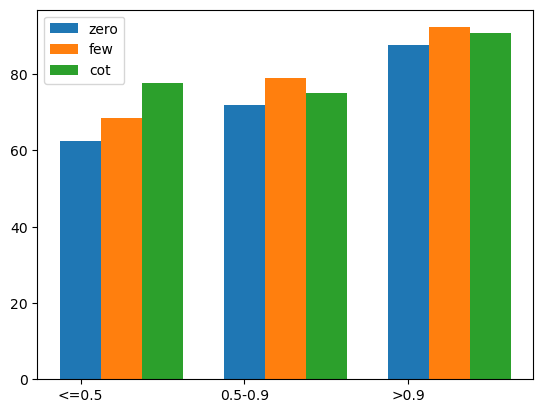

In [38]:
bins = [0.5, 0.9]
zmask, fmask, cmask, correct_mask = (prob_df["prompt"] == "zero", prob_df["prompt"] == "few", 
                                     prob_df["prompt"] == "cot", prob_df["expert"] == "CORRECT")
zh, fh, ch = [], [], []
xticks = []

for i in range(len(bins) + 1):
    if i == 0:
        mask = prob_df["prob"] <= bins[0]
        xticks.append(f"<={bins[0]}")
    elif i == len(bins):
        mask = prob_df["prob"] > bins[-1]
        xticks.append(f">{bins[-1]}")
    else:
        mask = (prob_df["prob"] <= bins[i]) & (prob_df["prob"] > bins[i-1])
        xticks.append(f"{bins[i-1]}-{bins[i]}")
    zh.append(100 * (zmask & mask & correct_mask).sum()/(zmask & mask).sum())
    fh.append(100 * (fmask & mask & correct_mask).sum()/(fmask & mask).sum())
    ch.append(100 * (cmask & mask & correct_mask).sum()/(cmask & mask).sum())

plt.bar(np.arange(len(bins) + 1), zh, width=0.25, label="zero")
plt.bar(np.arange(len(bins) + 1) + 0.25, fh, width=0.25, label="few")
plt.bar(np.arange(len(bins) + 1) + 0.5, ch, width=0.25, label="cot")
plt.legend()
plt.xticks(np.arange(len(bins) + 1), xticks)
plt.show()

In [10]:
prob_df["prob_norm"] = (1 - prob_df["prob"]).round(1)
prob_df["expert_norm"] = (prob_df["expert"] == "CORRECT").astype(int)

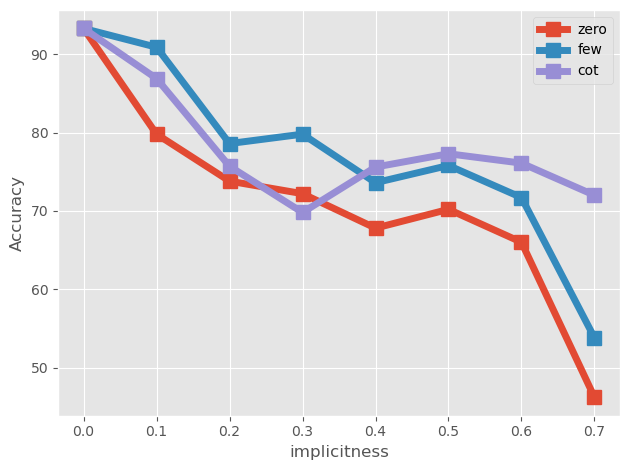

In [16]:
plt.style.use("ggplot")
for prompt in ["zero", "few", "cot"]:
    prompt_df = prob_df[prob_df["prompt"] == prompt]
    plot_df = (100*prompt_df.groupby("prob_norm")["expert_norm"].mean()).round(1)
    x, y = plot_df.index.tolist(), plot_df.values.tolist()
    plt.plot(x, y, label=prompt, lw=5, marker="s", markersize=10)
plt.legend()
plt.xlabel("implicitness")
plt.ylabel("Accuracy")
plt.tight_layout()
tikzplotlib.save(tex_file)

## Create error sample df

In [17]:
# attribute, id, text, character, prompt, answer, expert
rows = []

for df in xl.values():
    attr = df["attribute"].values[0]
    if attr not in ["physical health status", "physical appearance", "possessions"]:
        mask = df["Expert"].notna() & df["Expert"].str.match(r"(CORRECT)|(WRONG)")
        for _, attr_row in df[mask].iterrows():
            for prompt in attr_row["strategies"].split(","):
                rows.append([attr, attr_row["index"], attr_row["passage"], attr_row["character"], prompt, 
                             attr_row["model_answer"], attr_row["Expert"], attr_row["Reason"]])

analyze_df = pd.DataFrame(rows, 
                          columns=["attribute", "index", "text", "character", "prompt", "answer", "expert", "reason"])
analyze_df.head()

,attribute,index,text,character,prompt,answer,expert,reason
0,accomplishments,0,"They walk into Bradlee's office, where we stay...",Ben Bradlee,zero,Upholding the publication of the Pentagon Pape...,WRONG,WRONG/MISSING
1,accomplishments,0,"They walk into Bradlee's office, where we stay...",Ben Bradlee,cot,Stayed on as executive editor of the Washingto...,CORRECT,NaN
2,accomplishments,0,"They walk into Bradlee's office, where we stay...",Ben Bradlee,few,Upholding the publication of the Pentagon Pape...,WRONG,WRONG/MISSING
3,accomplishments,1,"They walk into Bradlee's office, where we stay...",BRADLEE,zero,Upholding the publication of the Pentagon Pape...,WRONG,DIFF CHARACTER
4,accomplishments,1,"They walk into Bradlee's office, where we stay...",BRADLEE,few,Uphold the publication of the Pentagon Papers;...,WRONG,DIFF CHARACTER


## Statistical Test

In [18]:
def statistical_test(arr_x, arr_y):
    return scipy.stats.ttest_rel(arr_x, arr_y, alternative="two-sided").pvalue # Ha: mean(arr_x) < mean(arr_y)

for attr, attr_df in analyze_df.groupby("attribute"):
    print(attr)
    for prompt_x, prompt_y in [("zero", "few"), ("zero", "cot"), ("cot", "few")]:
        arr_x, arr_y = [], []
        for _, attr_index_df in attr_df.groupby("index"):
            prompts = attr_index_df["prompt"].tolist()
            if prompt_x in prompts and prompt_y in prompts:
                x = int(attr_index_df.loc[attr_index_df["prompt"] == prompt_x, "expert"].item() == "CORRECT")
                y = int(attr_index_df.loc[attr_index_df["prompt"] == prompt_y, "expert"].item() == "CORRECT")
                arr_x.append(x)
                arr_y.append(y)
        mean_x, mean_y = np.mean(arr_x), np.mean(arr_y)
        pval = statistical_test(arr_x, arr_y)
        sign = "<" if mean_x < mean_y else ">"
        print(f"\t{prompt_x:4s} ({100*mean_x:.1f}) {sign} {prompt_y:4s} ({100*mean_y:.1f}): "
              f"{pval:.3f} ({pval < 0.05/3})")

accomplishments
	zero (64.4) < few  (71.1): 0.445 (False)
	zero (64.4) < cot  (71.1): 0.473 (False)
	cot  (71.1) > few  (71.1): 1.000 (False)
age
	zero (98.1) > few  (86.8): 0.033 (False)
	zero (98.1) > cot  (90.6): 0.044 (False)
	cot  (90.6) > few  (86.8): 0.485 (False)
attire
	zero (85.7) < few  (91.8): 0.322 (False)
	zero (85.7) < cot  (87.8): 0.743 (False)
	cot  (87.8) < few  (91.8): 0.485 (False)
attitude
	zero (86.7) < few  (95.6): 0.103 (False)
	zero (86.7) < cot  (93.3): 0.261 (False)
	cot  (93.3) < few  (95.6): 0.570 (False)
demeanor
	zero (72.0) < few  (84.0): 0.032 (False)
	zero (72.0) < cot  (78.0): 0.444 (False)
	cot  (78.0) < few  (84.0): 0.371 (False)
emotion
	zero (90.2) > few  (84.3): 0.083 (False)
	zero (90.2) > cot  (74.5): 0.031 (False)
	cot  (74.5) < few  (84.3): 0.133 (False)
eyes
	zero (40.0) < few  (82.0): 0.000 (True)
	zero (40.8) < cot  (81.6): 0.000 (True)
	cot  (81.6) > few  (81.6): 1.000 (False)
goal
	zero (62.5) < few  (66.7): 0.598 (False)
	zero (62.5) > 

In [19]:
for reason in ['ANSWER EXISTS', 'WRONG/MISSING', 'DIFF CHARACTER', 'DIFF ATTRIBUTE']:
    print(reason)
    for prompt_x, prompt_y in [("zero", "few"), ("zero", "cot"), ("cot", "few")]:
        arr_x, arr_y = [], []
        for _, index_df in analyze_df.groupby(["index", "attribute"]):
            index_prompts = index_df["prompt"].tolist()
            if prompt_x in index_prompts and prompt_y in index_prompts:
                x = int((index_df.loc[index_df["prompt"] == prompt_x, "expert"].item() == "WRONG")
                        and (index_df.loc[index_df["prompt"] == prompt_x, "reason"].item() == reason))
                y = int((index_df.loc[index_df["prompt"] == prompt_y, "expert"].item() == "WRONG")
                        and (index_df.loc[index_df["prompt"] == prompt_y, "reason"].item() == reason))
                arr_x.append(x)
                arr_y.append(y)
        mean_x, mean_y = np.mean(arr_x), np.mean(arr_y)
        pval = statistical_test(arr_x, arr_y)
        sign = "<" if mean_x < mean_y else ">"
        print(f"\t{prompt_x:4s} ({100*mean_x:4.1f}) {sign} {prompt_y:4s} ({100*mean_y:4.1f}): "
              f"{pval:.3f} ({pval < 0.05/3})")

ANSWER EXISTS
	zero (11.4) > few  ( 4.1): 0.000 (True)
	zero (11.2) > cot  ( 7.0): 0.000 (True)
	cot  ( 6.9) > few  ( 4.1): 0.004 (True)
WRONG/MISSING
	zero (11.9) > few  (11.6): 0.821 (False)
	zero (11.9) > cot  (11.1): 0.619 (False)
	cot  (11.2) < few  (11.6): 0.736 (False)
DIFF CHARACTER
	zero ( 2.0) < few  ( 2.1): 0.796 (False)
	zero ( 2.0) < cot  ( 2.3): 0.617 (False)
	cot  ( 2.3) > few  ( 2.1): 0.782 (False)
DIFF ATTRIBUTE
	zero ( 1.8) < few  ( 2.6): 0.096 (False)
	zero ( 1.8) > cot  ( 1.1): 0.166 (False)
	cot  ( 1.1) < few  ( 2.6): 0.004 (True)
